Analysis Rsync and Beaver's bidding of the 921 blocks won by Titan

Author: Bryanzk
Date Modified: 2024.06.18
License: CC0

In [13]:

# ##############################
# A TEST GROUND FOR TESTING CODE
# ##############################



# import pandas as pd # type: ignore

# df = get_raw_block_data_with_winning_bids_and_latest_builder_label_from_CSV()
    

# df = df.dropna(subset=['bid_timestamp_ms'])

# df['block_datetime'] = pd.to_datetime(df['block_datetime'])


# df.loc[:,'org_bid_timestamp_ms'] = df['bid_timestamp_ms']
    
# df.loc[:,'bid_timestamp_ms'] = df['bid_timestamp_ms'].astype('int64') # 确保时间戳为整数
# df.loc[:,'bid_timestamp_ms'] = pd.to_datetime(df['bid_timestamp_ms'], unit='ms')

# # 计算时间差并且存储在新的 Dataframe 中 Calculate the time difference and store it in a new Dataframe.
# ts_diff_df = (df['block_datetime'] - df['bid_timestamp_ms']).apply(lambda x: x.total_seconds()) * 1000
# ts_diff_df = ts_diff_df.apply(lambda x: 0 if abs(x) < 0.001 else x)

# # 添加新的列到原始的 Dataframe 中.  Add a new column, ts_diff, as ms difference, to the original Dataframe.
# # if ts_diff > 0, bid before 12s, if ts_diff<0, bid after 12s
# df = pd.concat([df, ts_diff_df.rename('ts_diff')], axis=1)

# df['ts_diff_secs'] = df['ts_diff'] / 1000


In [14]:
### Get the bidding data for the 921 blocks that Titan won. This is the most time consuming part of the data preparation process.
from data_prep_utils import *
from plot_prep_utils import *
import matplotlib.pyplot as plt # type: ignore
import numpy as np # type: ignore
import os
import pandas as pd # type: ignore
import requests
from bs4 import BeautifulSoup


# Read the blocks data between the min and max of the titan 921 blocks
df_blocks = get_block_data_with_winning_bids_having_bid_ts()

# Read 921 blocks' bidding data. Titan won these 921 blocks.
pd.options.display.float_format = '{:.0f}'.format
# Read the titan 921 block bidding history parquet file
df_bidding = get_titan_won_921_blocks_bidding_data()
# print(df_bidding.columns)

# Filter the blocks data to only include the blocks that are in the 921 blocks bidding data
df_blocks = df_blocks[df_blocks['block_number'].isin(df_bidding['block_number'].unique())]



/Users/kezheng/temp/mevboost-data/examples/data_prep_utils.py:162: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '<DatetimeArray>
['2024-03-14 01:31:22.806000', '2024-03-14 01:31:47.445000',
 '2024-03-14 01:31:59.781000', '2024-03-14 01:34:35.641000',
 '2024-03-14 01:35:59.155000', '2024-03-14 01:36:59.539000',
 '2024-03-14 01:37:10.877000', '2024-03-14 01:38:12.861000',
 '2024-03-14 01:39:34.468000', '2024-03-14 01:40:12.790000',
 ...
 '2024-03-16 20:57:35.697000', '2024-03-16 20:57:47.264000',
 '2024-03-16 20:58:11.693000', '2024-03-16 20:58:47.828000',
 '2024-03-16 20:58:59.711000', '2024-03-16 20:59:23.252000',
 '2024-03-16 21:01:11.267000', '2024-03-16 21:01:23.780000',
 '2024-03-16 21:03:23.167000', '2024-03-16 21:03:35.779000']
Length: 2781, dtype: datetime64[ns]' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df.loc[:,'bid_timestamp_ms'] = pd.to_datetime(df['bid_ti

Index(['block_timestamp', 'relay', 'slot', 'parent_hash', 'block_hash',
       'builder_pubkey', 'proposer_pubkey', 'proposer_fee_recipient',
       'gas_limit', 'gas_used', 'value', 'num_tx', 'block_number', 'timestamp',
       'timestamp_s', 'timestamp_ms', 'optimistic_submission'],
      dtype='object')
bidding - columns - after merge on block number:
Index(['block_timestamp', 'relay', 'slot', 'parent_hash', 'block_hash',
       'builder_pubkey', 'proposer_pubkey', 'proposer_fee_recipient',
       'gas_limit', 'gas_used', 'value', 'num_tx', 'block_number', 'timestamp',
       'timestamp_s', 'timestamp_ms', 'optimistic_submission', 'ts_diff',
       'ts_diff_secs', 'builder_label'],
      dtype='object')
bidding - rows - after merge on block number:
1698090
bidding - empty builder label rows - after merge on block number:
10053
bidding - TLDR filled builder label counts - after merge on block number:
24
bidding - TLDR filled builder label counts - after merge on block number and fill

In [15]:
# Filter out the duplicate block_number records with the earliest bid_timestamp, which is the winning bid thru the fastest relay
# N.B.: this would omit the records with the same block_number but different bid_timestamp from differe relays
df_filtered = df_blocks.copy()
df_filtered = df_filtered.sort_values(['block_number', 'bid_timestamp_ms'])
df_filtered = df_filtered.drop_duplicates('block_number', keep='first')

# get the unique block numbers won by Titan
unique_block_numbers_won_by_titan = df_bidding['block_number'].unique()

df_filtered_titan = df_filtered[df_filtered['block_number'].isin(unique_block_numbers_won_by_titan)]
# df_filtered_titan.loc[:,'bid_timestamp_ms'] = pd.to_datetime(df_filtered['bid_timestamp_ms'], unit='ms')
print(df_filtered_titan.shape[0])

921


In [16]:
def add_watermark(ax, image_path, zoom=0.2, alpha=0.3, position=(0.5, 0.5)):
    """
    Adds a watermark to a given axis.
    
    Parameters:
    - ax: The matplotlib axis where the watermark will be added.
    - image_path: Path to the image to be used as the watermark.
    - zoom: Scaling factor for the image.
    - alpha: Transparency of the image.
    - position: A tuple specifying the position of the image in axes fraction coordinates (0 to 1).
    """
    # Load the image
    image = mpimg.imread(image_path)
    
    # Create an OffsetImage and set the zoom and alpha
    imagebox = OffsetImage(image, zoom=zoom, alpha=alpha)  
    
    # Create the AnnotationBbox with the desired location
    ab = AnnotationBbox(imagebox, position,
                        xycoords='axes fraction',
                        frameon=False)  
    
    # Add the image to the axis
    ax.add_artist(ab)



In [17]:
#Now the data is ready. Time to draw.
# Plot the stacked barchart of Titan's block 
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.ticker as ticker
import matplotlib.image as mpimg
from matplotlib.offsetbox import OffsetImage, AnnotationBbox


# # 计算 ts_diff 的最小和最大值
# x_min = np.floor(df_filtered_titan['ts_diff_secs'].min())
# x_max = np.ceil(df_filtered_titan['ts_diff_secs'].max())
# # print ("min:" + str(x_min) + "; max:" + str(x_max))


# # 创建 `ts_diff_secs` 的区间（每0.1秒）
# df_filtered_titan.loc[:,'ts_diff_bins'] = pd.cut(
#     df_filtered_titan['ts_diff_secs'], 
#     np.arange(x_min, x_max + 0.1, 0.1)  # 使用 x_min 和 x_max
# )


# df_filtered_titan.loc[:,'ts_diff_bins'] = df_filtered_titan['ts_diff_bins'].apply(lambda interval: pd.Interval(replace_small_values(interval.left), 
#                                                                            replace_small_values(interval.right),
#                                                                            interval.closed))


# grouped = df_filtered_titan.groupby('ts_diff_bins')['block_number'].count()

# ax = grouped.plot(kind='bar', figsize=(10,6), color='yellow')

# adjust_plot_x_axis(ax)

# plt.xlabel('ts_diff (seconds)', fontsize=12)
# plt.ylabel('Won Blocks', fontsize=12)
# plt.title('921 Blocks won by Titan Bid Timing Distribution')

# # Adding watermark using the refactored function
# add_watermark(ax, image_path='EigenPhi_logo.png', zoom=0.2, alpha=0.05, position=(0.5, 0.5))

# plt.show()

# # save the grouped data to clipboard
# grouped_transposed = grouped.transpose()
# grouped_transposed.to_clipboard(index=True, header=True)

# # draw the chart of average and median number of transactions in the blocks won by Titan
# grouped_avg = df_filtered_titan.groupby('ts_diff_bins')['num_tx'].mean().reset_index(name='avg_num_tx')
# grouped_med = df_filtered_titan.groupby('ts_diff_bins')['num_tx'].median().reset_index(name='med_num_tx')
# merged_df = pd.merge(grouped_avg, grouped_med, on='ts_diff_bins')


# txplot = merged_df.plot(x='ts_diff_bins', y=['avg_num_tx', 'med_num_tx'], kind='bar', color=['red', 'blue'], figsize=(10,6))
# adjust_plot_x_axis(txplot)
# plt.xlabel('ts_diff (seconds)', fontsize=12)
# plt.ylabel('Tx Count in Won Blocks', fontsize=12)
# plt.title('Avg and Median Tx Count of 921 Blocks won by Titan Bid Timing Distribution')

# # Adding watermark using the refactored function
# add_watermark(txplot, image_path='EigenPhi_logo.png', zoom=0.2, alpha=0.05, position=(0.5, 0.5))


# # # save the grouped data to clipboard
# # tx_grouped_transposed = merged_df.transpose()
# # merged_df.to_clipboard(index=True, header=True)



# # Chart 3: Average and median value in the blocks won by Titan

# # Create a copy of the filtered Titan data to avoid modifying the original data
# df_filtered_titan_bids_value = df_filtered_titan.copy()
# # Adjust the value column by dividing by 10**18
# df_filtered_titan_bids_value['value'] = df_filtered_titan_bids_value['value'] / 10**18

# grouped_avg_value = df_filtered_titan_bids_value.groupby('ts_diff_bins')['value'].mean().reset_index(name='avg_value')
# grouped_med_value = df_filtered_titan_bids_value.groupby('ts_diff_bins')['value'].median().reset_index(name='med_value')
# merged_df_value = pd.merge(grouped_avg_value, grouped_med_value, on='ts_diff_bins')


# ax3 = merged_df_value.plot(x='ts_diff_bins', y=['avg_value', 'med_value'], kind='bar', color=['darkorange', 'royalblue'], figsize=(10, 6))


# adjust_plot_x_axis(ax3)
# plt.xlabel('ts_diff (seconds)', fontsize=12)
# plt.ylabel('Value in Won Blocks', fontsize=12)
# plt.title('Avg and Median Bid Value of Titan Blocks by Bid Timing')
# add_watermark(ax3, image_path='EigenPhi_logo.png', zoom=0.2, alpha=0.05, position=(0.5, 0.5))
# plt.show()

# # print(merged_df_value.columns)

# # Chart 4: Average and median Gas_used in the blocks won by Titan

# # Create a copy of the filtered Titan data to avoid modifying the original data
# df_filtered_titan_bids_gas = df_filtered_titan.copy()

# grouped_avg_gas = df_filtered_titan_bids_gas.groupby('ts_diff_bins')['gas_used'].mean().reset_index(name='avg_gas')
# grouped_med_gas = df_filtered_titan_bids_gas.groupby('ts_diff_bins')['gas_used'].median().reset_index(name='med_gas')
# merged_df_gas = pd.merge(grouped_avg_gas, grouped_med_gas, on='ts_diff_bins')

# ax4 = merged_df_gas.plot(x='ts_diff_bins', y=['avg_gas', 'med_gas'], kind='bar', color=['red', 'green'], figsize=(10, 6))

# adjust_plot_x_axis(ax4)
# plt.xlabel('ts_diff (seconds)', fontsize=12)
# plt.ylabel('Gas Used in Won Blocks', fontsize=12)
# plt.title('Avg and Median Gas Used of Titan Blocks by Bid Timing')
# add_watermark(ax4, image_path='EigenPhi_logo.png', zoom=0.2, alpha=0.05, position=(0.5, 0.5))
# plt.show()


# # # Save the grouped data to clipboard
# # merged_df_value.transpose().to_clipboard(index=True, header=True)



all max ts_diff_secs10.725
all min_ts_diff_secs-11.985
min:-12.0; max:11.0


/var/folders/mf/lxpn1ltx7t97r1v1k92vly1w0000gn/T/ipykernel_69619/2095386338.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dft_bidding12s.loc[:,'ts_diff_bins'] = pd.cut(
/var/folders/mf/lxpn1ltx7t97r1v1k92vly1w0000gn/T/ipykernel_69619/2095386338.py:33: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[(1.3, 1.4], (0.7, 0.8], (0.1, 0.2], (-1.4, -1.3], (-0.5, -0.4], ..., (0.9, 1.0], (-1.5, -1.4], (0.7, 0.8], (1.5, 1.6], (0.9, 1.0]]
Length: 1695372
Categories (230, interval[float64, right]): [(-12.0, -11.9] < (-11.9, -11.8] < (-11.8, -11.7] < (-11.7, -11.6] ... (10.6, 10.7] < (10.7, 10.8] < (10.8, 10.9] < (10.9, 11.0]]' has dtype incompatible with category, please explicitly 

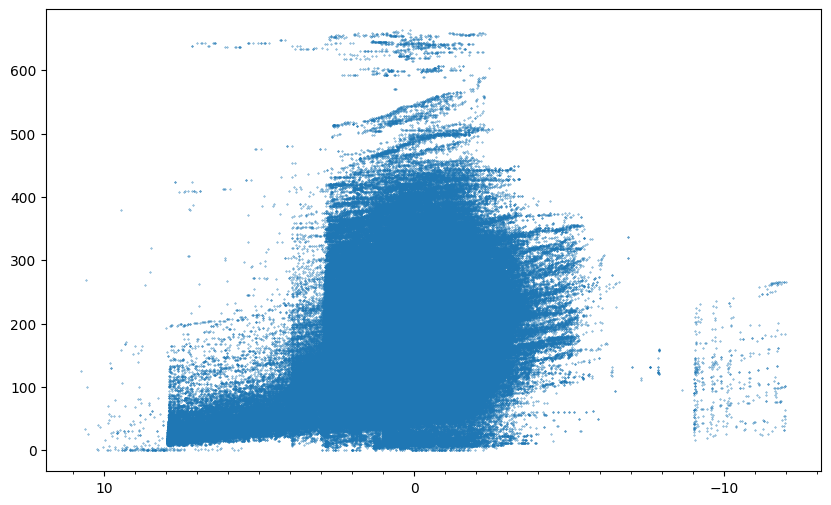

In [18]:
#Now the data is ready. Time to draw.
# Plot the stacked barchart of builder label with ts_diff as the x-axis
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import matplotlib.ticker as ticker
import matplotlib.image as mpimg
from matplotlib.offsetbox import OffsetImage, AnnotationBbox


dft_bidding12s = df_bidding[df_bidding['ts_diff_secs'] > -12]

max_ts_diff_secs = dft_bidding12s['ts_diff_secs'].max()
print("all max ts_diff_secs" + str(max_ts_diff_secs))

min_ts_diff_secs = dft_bidding12s['ts_diff_secs'].min()
# print(dft_bidding12s[dft_bidding12s['ts_diff_secs'] == min_ts_diff_secs])
print("all min_ts_diff_secs" + str(min_ts_diff_secs))

# 计算 ts_diff 的最小和最大值
x_min = np.floor(dft_bidding12s['ts_diff_secs'].min())
x_max = np.ceil(dft_bidding12s['ts_diff_secs'].max())
print ("min:" + str(x_min) + "; max:" + str(x_max))


# 创建 `ts_diff_secs` 的区间（每0.1秒）
dft_bidding12s.loc[:,'ts_diff_bins'] = pd.cut(
    dft_bidding12s['ts_diff_secs'], 
    np.arange(x_min, x_max + 0.1, 0.1)  # 使用 x_min 和 x_max
)

dft_bidding12s.loc[:,'ts_diff_bins'] = dft_bidding12s['ts_diff_bins'].apply(lambda interval: pd.Interval(replace_small_values(interval.left), 
                                                                           replace_small_values(interval.right),
                                                                           interval.closed))

fig, ax = plt.subplots(figsize=(10,6))
adjust_plot_x_axis(ax)

# Plot without separating builders
ax.scatter(dft_bidding12s['ts_diff_secs'], dft_bidding12s['num_tx'], s=0.1)

# # # 获取图例并修改点的大小
# # legend = plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), fancybox=True, shadow=True, ncol=5)
# # for handle in legend.legendHandles:
# #     handle._sizes = [30]

# ax.xaxis.set_major_locator(ticker.MultipleLocator(base=1))  # 设置主要刻度为1秒

# plt.xlabel('ts_diff (seconds)', fontsize=12)
# plt.ylabel('Bids Tx Count', fontsize=12)
# plt.title('921 Blocks won by Titan - Bidding data from all all builders - Tx Counts Distribution')

# # Adding watermark using the refactored function
# add_watermark(ax, image_path='EigenPhi_logo.png', zoom=0.2, alpha=0.05, position=(0.5, 0.5))

# plt.show()

# # Chart 2: on Gas Used
# fig, ax2 = plt.subplots(figsize=(10,6))
# adjust_plot_x_axis(ax2)

# # Plot without separating builders
# ax2.scatter(dft_bidding12s['ts_diff_secs'], dft_bidding12s['gas_used'], s=0.1)

# # # 获取图例并修改点的大小
# # legend = plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), fancybox=True, shadow=True, ncol=5)
# # for handle in legend.legendHandles:
# #     handle._sizes = [30]

# ax2.xaxis.set_major_locator(ticker.MultipleLocator(base=1))  # 设置主要刻度为1秒

# plt.xlabel('ts_diff (seconds)', fontsize=12)
# plt.ylabel('Gas Used', fontsize=12)
# plt.title('921 Blocks won by Titan - Bidding data from all all builders - Gas Used Distribution')

# # Adding watermark using the refactored function
# add_watermark(ax2, image_path='EigenPhi_logo.png', zoom=0.2, alpha=0.05, position=(0.5, 0.5))



In [19]:
# #Now the data is ready. Time to draw.
# # Plot the stacked barchart of builder label with ts_diff as the x-axis
# import matplotlib.cm as cm
# import matplotlib.pyplot as plt
# import numpy as np
# import matplotlib.ticker as ticker

# dft_bidding12s = df_bidding[df_bidding['ts_diff_secs'] > -12]

# max_ts_diff_secs = dft_bidding12s['ts_diff_secs'].max()
# print("all max ts_diff_secs" + str(max_ts_diff_secs))

# min_ts_diff_secs = dft_bidding12s['ts_diff_secs'].min()
# # print(dft_bidding12s[dft_bidding12s['ts_diff_secs'] == min_ts_diff_secs])
# print("all min_ts_diff_secs" + str(min_ts_diff_secs))

# # 计算 ts_diff 的最小和最大值
# x_min = np.floor(dft_bidding12s['ts_diff_secs'].min())
# x_max = np.ceil(dft_bidding12s['ts_diff_secs'].max())
# print ("min:" + str(x_min) + "; max:" + str(x_max))


# # 创建 `ts_diff_secs` 的区间（每0.1秒）
# dft_bidding12s.loc[:,'ts_diff_bins'] = pd.cut(
#     dft_bidding12s['ts_diff_secs'], 
#     np.arange(x_min, x_max + 0.1, 0.1)  # 使用 x_min 和 x_max
# )


# dft_bidding12s.loc[:,'ts_diff_bins'] = dft_bidding12s['ts_diff_bins'].apply(lambda interval: pd.Interval(replace_small_values(interval.left), 
#                                                                            replace_small_values(interval.right),
#                                                                            interval.closed))

# fig, ax = plt.subplots(figsize=(10,6))
# adjust_plot_x_axis(ax)


# for label in dft_bidding12s['builder_label'].unique():
#     dft_label = dft_bidding12s[dft_bidding12s['builder_label'] == label]
#     ax.scatter(dft_label['ts_diff_secs'], dft_label['num_tx'], s=0.1, label=label)
    
# # 获取图例并修改点的大小
# legend = plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), fancybox=True, shadow=True, ncol=5)
# for handle in legend.legendHandles:
#     handle._sizes = [30]

# ax.xaxis.set_major_locator(ticker.MultipleLocator(base=1))  # 设置主要刻度为1秒

# plt.xlabel('ts_diff (seconds)', fontsize=12)
# plt.ylabel('Bids Tx Count', fontsize=12)
# plt.title('921 Blocks won by Titan - Bidding data from all all builders - Tx Counts Distribution')

# # Adding watermark using the refactored function
# add_watermark(ax, image_path='EigenPhi_logo.png', zoom=0.2, alpha=0.05, position=(0.5, 0.5))

# plt.show()

# # Chart2: on Gas Used 
# fig, ax2 = plt.subplots(figsize=(10,6))
# adjust_plot_x_axis(ax2)
# for label in dft_bidding12s['builder_label'].unique():
#     dft_label = dft_bidding12s[dft_bidding12s['builder_label'] == label]
#     ax2.scatter(dft_label['ts_diff_secs'], dft_label['gas_used'], s=0.1, label=label)
    
# # 获取图例并修改点的大小
# legend = plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), fancybox=True, shadow=True, ncol=5)
# for handle in legend.legendHandles:
#     handle._sizes = [30]

# ax2.xaxis.set_major_locator(ticker.MultipleLocator(base=1))  # 设置主要刻度为1秒

# plt.xlabel('ts_diff (seconds)', fontsize=12)
# plt.ylabel('Bids Tx Count', fontsize=12)
# plt.title('921 Blocks won by Titan - Bidding data from all all builders - Gas Used Distribution')

# # Adding watermark using the refactored function
# add_watermark(ax2, image_path='EigenPhi_logo.png', zoom=0.2, alpha=0.05, position=(0.5, 0.5))

# plt.show()



In [20]:
# # Draw the scatter plot of overall bid values
# fig_bid, ax_bid = plt.subplots(figsize=(10, 6))
# adjust_plot_x_axis(ax_bid)

# # Plot all data points together without separating builders
# ax_bid.scatter(dft_bidding12s['ts_diff_secs'], dft_bidding12s['value']/10**18, s=0.1)

# ax_bid.xaxis.set_major_locator(ticker.MultipleLocator(base=1))  # 设置主要刻度为1秒

# plt.xlabel('ts_diff (seconds)', fontsize=12)
# plt.ylabel('Bids Value (Eth)', fontsize=12)
# plt.title('921 Blocks won by Titan - Bidding data from all builders - Bid Value Distribution')

# # Adding watermark using the refactored function
# add_watermark(ax_bid, image_path='EigenPhi_logo.png', zoom=0.2, alpha=0.05, position=(0.5, 0.5))

# plt.show()



In [21]:
# # draw the scatter plot of bid values
# fig_bid, ax_bid = plt.subplots(figsize=(10,6))
# adjust_plot_x_axis(ax_bid)
# for label in dft_bidding12s['builder_label'].unique():
#     dft_label = dft_bidding12s[dft_bidding12s['builder_label'] == label]
#     ax_bid.scatter(dft_label['ts_diff_secs'], dft_label['value']/10**18, s=0.1, label=label)
    
# # 获取图例并修改点的大小
# legend = plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), fancybox=True, shadow=True, ncol=5)
# for handle in legend.legendHandles:
#     handle._sizes = [30]

# ax_bid.xaxis.set_major_locator(ticker.MultipleLocator(base=1))  # 设置主要刻度为1秒

# plt.xlabel('ts_diff (seconds)', fontsize=12)
# plt.ylabel('Bids Value (Eth)', fontsize=12)
# plt.title('921 Blocks won by Titan - Bidding data from all all builders - Bid Value Distribution')

# # Adding watermark using the refactored function
# add_watermark(ax_bid, image_path='EigenPhi_logo.png', zoom=0.2, alpha=0.05, position=(0.5, 0.5))

# plt.show()


# # # draw the scatter plot of Gas Used
# # fig_gas, ax_gas = plt.subplots(figsize=(10,6))
# # adjust_plot_x_axis(ax_gas)
# # for label in dft_bidding12s['builder_label'].unique():
# #     dft_label = dft_bidding12s[dft_bidding12s['builder_label'] == label]
# #     ax_gas.scatter(dft_label['ts_diff_secs'], dft_label['gas_used'], s=0.1, label=label)
    
# # # 获取图例并修改点的大小
# # legend = plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), fancybox=True, shadow=True, ncol=5)
# # for handle in legend.legendHandles:
# #     handle._sizes = [30]

# # ax_gas.xaxis.set_major_locator(ticker.MultipleLocator(base=1))  # 设置主要刻度为1秒

# # plt.xlabel('ts_diff (seconds)', fontsize=12)
# # plt.ylabel('Gas Used', fontsize=12)
# # plt.title('921 Blocks won by Titan - Bidding data from all all builders - Gas Used Distribution')

# # # Adding watermark using the refactored function
# # add_watermark(ax_gas, image_path='EigenPhi_logo.png', zoom=0.2, alpha=0.05, position=(0.5, 0.5))

# # plt.show()


In [22]:
print(dft_bidding12s.columns)
print(dft_bidding12s['builder_label'].unique())
print(dft_bidding12s[dft_bidding12s['builder_label'].isna()].shape[0])
# print(df_blocks.columns)

Index(['block_timestamp', 'relay', 'slot', 'parent_hash', 'block_hash',
       'builder_pubkey', 'proposer_pubkey', 'proposer_fee_recipient',
       'gas_limit', 'gas_used', 'value', 'num_tx', 'block_number', 'timestamp',
       'timestamp_s', 'timestamp_ms', 'optimistic_submission', 'ts_diff',
       'ts_diff_secs', 'builder_label', 'ts_diff_bins'],
      dtype='object')
['Titan' 'beaverbuild' 'rsync' 'lokibuilder' 'antbuilder' 'builder0x69'
 'jetbldr' 'bloXroute' 'BuildAI' 'EigenPhi' 'bobTheBuilder' 'flashbots'
 'FAILED_BUILDER_0xa3ad1da9' 'Gambit Labs' 'tbuilder' 'BTCS'
 'FAILED_BUILDER_0x8741ffa1' 'smithbot' 'ashpool' 'penguin' 'Manifold'
 'boba-builder' 'FAILED_BUILDER_0xa5ac80a8' 'FAILED_BUILDER_0x83bee517'
 'FAILED_BUILDER_0xb3a6dc1f' 'I can haz block?'
 'FAILED_BUILDER_0x85beff52' 'f1b' 'imposter' 'default key']
0


In [23]:

# Draw the charts of Rsync
dft_bidding12s_titan_only = dft_bidding12s[dft_bidding12s['builder_label']=='Titan']
dft_bidding12s_beaver_only = dft_bidding12s[dft_bidding12s['builder_label']=='beaverbuild']
dft_bidding12s_rsync_only = dft_bidding12s[dft_bidding12s['builder_label']=='rsync']

#find out the biggest and smallest ts_diff_secs for the axis
max_rsync_ts_diff_secs = dft_bidding12s_rsync_only['ts_diff_secs'].max()
min_rsync_ts_diff_secs = dft_bidding12s_rsync_only['ts_diff_secs'].min()

max_beaver_ts_diff_secs = dft_bidding12s_beaver_only['ts_diff_secs'].max()
min_beaver_ts_diff_secs = dft_bidding12s_beaver_only['ts_diff_secs'].min()


max_x_axis = max(max_beaver_ts_diff_secs, max_rsync_ts_diff_secs)
min_x_axis = min(min_beaver_ts_diff_secs, min_rsync_ts_diff_secs)


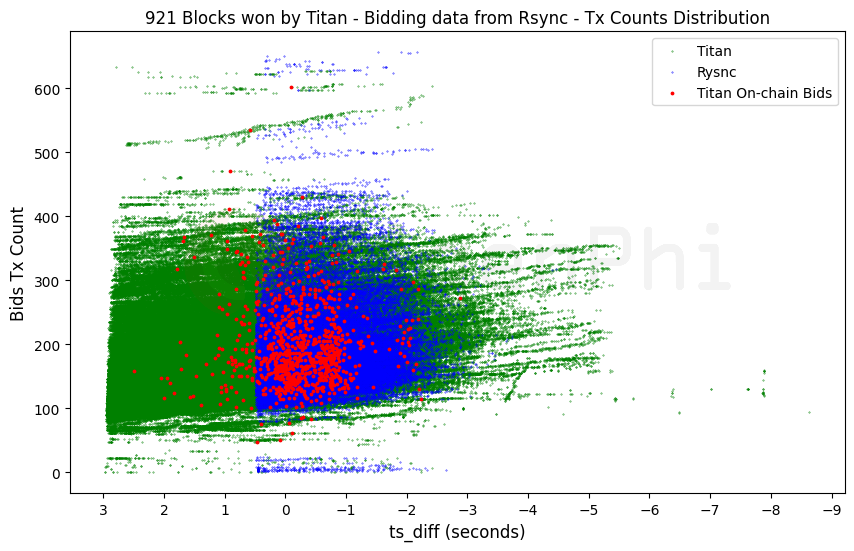

In [25]:
# Chart1: on Tx Count

#The code that put Titan on it
bx_num_tx = dft_bidding12s_titan_only.plot.scatter(x='ts_diff_secs', y='num_tx', color='green', s=0.1, label='Titan')



bx_num_tx = dft_bidding12s_rsync_only.plot.scatter(x='ts_diff_secs', y='num_tx', figsize=(10,6), ax = bx_num_tx, color='blue', s=0.1, label='Rysnc')



# showing the tx counts of the on-chain bids from Titan
df_blocks.plot.scatter(x='ts_diff_secs', y='num_tx', color='red', s=3, 
                             ax=bx_num_tx, label='Titan On-chain Bids')


adjust_plot_x_axis(bx_num_tx)
bx_num_tx.xaxis.set_major_locator(ticker.MultipleLocator(base=1))  # 设置主要刻度为1秒
plt.xlabel('ts_diff (seconds)', fontsize=12)
plt.ylabel('Bids Tx Count', fontsize=12)
plt.title('921 Blocks won by Titan - Bidding data from Rsync - Tx Counts Distribution')
# plt.title('921 Blocks won by Titan - Bidding data from beaverbuild & Titan - Tx Counts Distribution')
# Adding watermark using the refactored function
add_watermark(bx_num_tx, image_path='EigenPhi_logo.png', zoom=0.2, alpha=0.05, position=(0.5, 0.5))
plt.show()


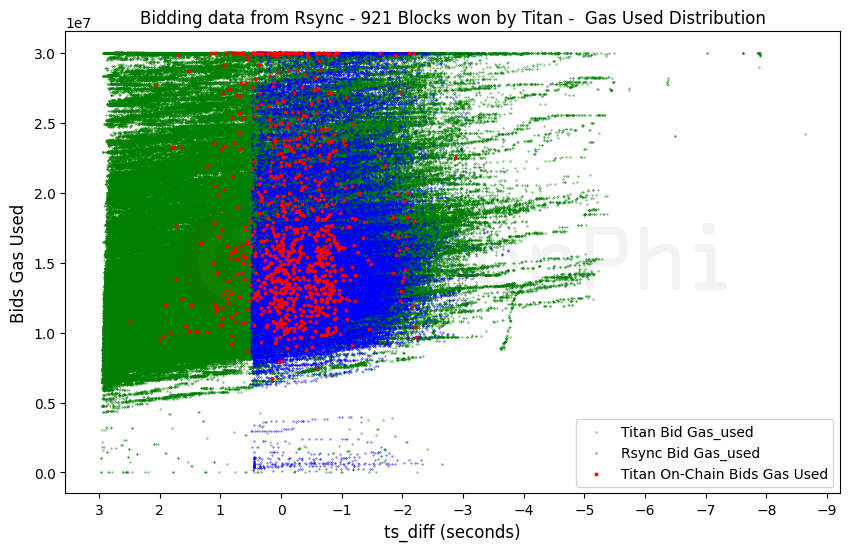

In [28]:



# Chart2: on Gas Used
#The code that put Titan on it
bx_gas = dft_bidding12s_titan_only.plot.scatter(x='ts_diff_secs', y='gas_used', color='green', s=0.1,  label='Titan Bid Gas_used')

dft_bidding12s_rsync_only.plot.scatter(x='ts_diff_secs', y='gas_used', figsize=(10,6), color='blue', s=0.1, ax=bx_gas, label='Rsync Bid Gas_used')


# showing the tx counts of the on-chain bids from Titan
df_blocks.plot.scatter(x='ts_diff_secs', y='gas_used', color='red', s=3, 
                             ax=bx_gas, label='Titan On-Chain Bids Gas Used')

adjust_plot_x_axis(bx_gas)
bx_gas.xaxis.set_major_locator(ticker.MultipleLocator(base=1))  # 设置主要刻度为1秒
plt.xlabel('ts_diff (seconds)', fontsize=12)
plt.ylabel('Bids Gas Used', fontsize=12)
plt.title('Bidding data from Rsync - 921 Blocks won by Titan -  Gas Used Distribution')
# plt.title('921 Blocks won by Titan - Bidding data from beaverbuild & Titan - Gas Used Distribution')
# Adding watermark using the refactored function
add_watermark(bx_gas, image_path='EigenPhi_logo.png', zoom=0.2, alpha=0.05, position=(0.5, 0.5))
plt.show()



/var/folders/mf/lxpn1ltx7t97r1v1k92vly1w0000gn/T/ipykernel_69619/4149442993.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dft_bidding12s_rsync_only['bid_transformed'] = dft_bidding12s_rsync_only['value'] / 10 ** 18
/var/folders/mf/lxpn1ltx7t97r1v1k92vly1w0000gn/T/ipykernel_69619/4149442993.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dft_bidding12s_titan_only['bid_transformed'] = dft_bidding12s_titan_only['value'] / 10 ** 18


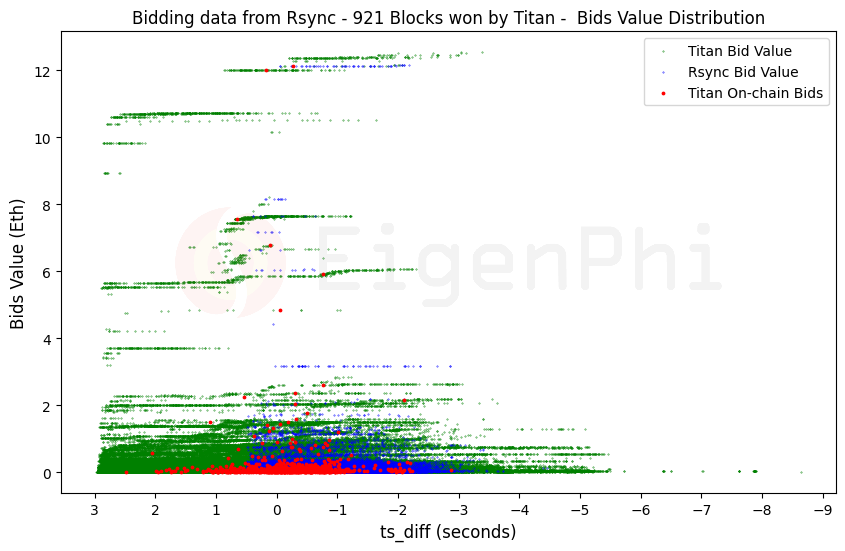

In [30]:


# Chart3: on Bid Value
# prepping the data for Bid Value scatter plot
dft_bidding12s_rsync_only['bid_transformed'] = dft_bidding12s_rsync_only['value'] / 10 ** 18
dft_bidding12s_titan_only['bid_transformed'] = dft_bidding12s_titan_only['value'] / 10 ** 18

df_blocks['bid_transformed'] = df_blocks['value'] / 10 ** 18


bx_value = dft_bidding12s_titan_only.plot.scatter(x='ts_diff_secs', y='bid_transformed', color='green', s=0.1,  label='Titan Bid Value')
dft_bidding12s_rsync_only.plot.scatter(x='ts_diff_secs', y='bid_transformed', figsize=(10,6), color='blue', s=0.1, label='Rsync Bid Value',ax=bx_value)

# showing the bid values of the on-chain bids
df_blocks.plot.scatter(x='ts_diff_secs', y='bid_transformed', color='red', s=3, ax=bx_value, label='Titan On-chain Bids')


adjust_plot_x_axis(bx_value)
bx_value.xaxis.set_major_locator(ticker.MultipleLocator(base=1))  # 设置主要刻度为1秒
plt.xlabel('ts_diff (seconds)', fontsize=12)
plt.ylabel('Bids Value (Eth)', fontsize=12)
plt.title('Bidding data from Rsync - 921 Blocks won by Titan -  Bids Value Distribution')

# Adding watermark using the refactored function
add_watermark(bx_value, image_path='EigenPhi_logo.png', zoom=0.2, alpha=0.05, position=(0.5, 0.5))

plt.show()





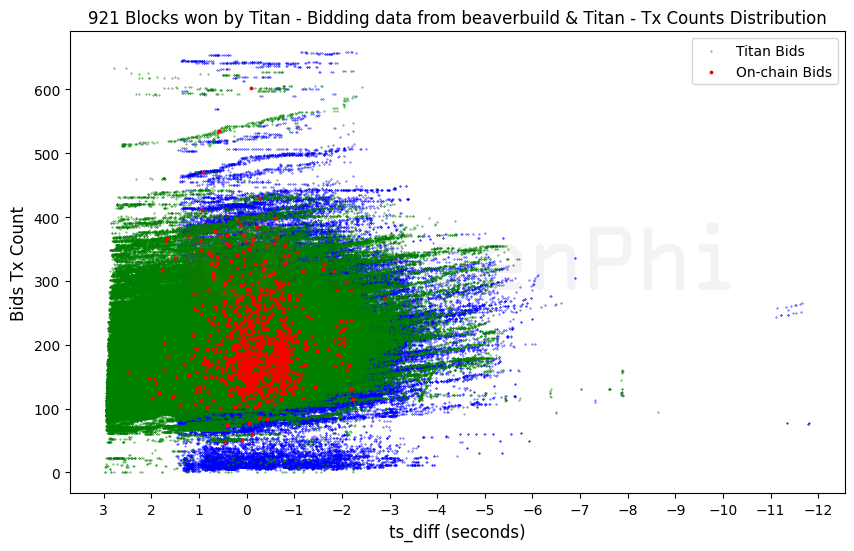

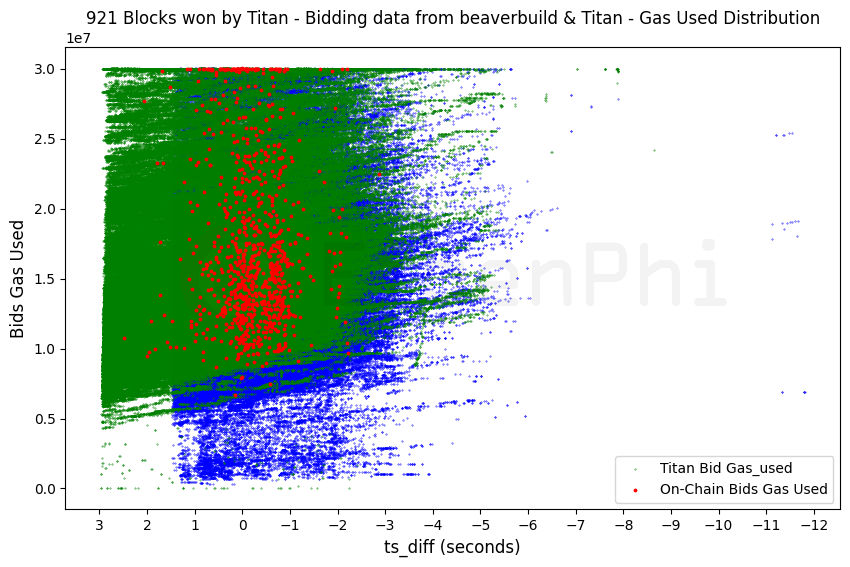

/var/folders/mf/lxpn1ltx7t97r1v1k92vly1w0000gn/T/ipykernel_84360/158532276.py:62: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dft_bidding12s_beaver_only['bid_transformed'] = dft_bidding12s_beaver_only['value'] / 10 ** 18
/var/folders/mf/lxpn1ltx7t97r1v1k92vly1w0000gn/T/ipykernel_84360/158532276.py:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dft_bidding12s_titan_only['bid_transformed'] = dft_bidding12s_titan_only['value'] / 10 ** 18


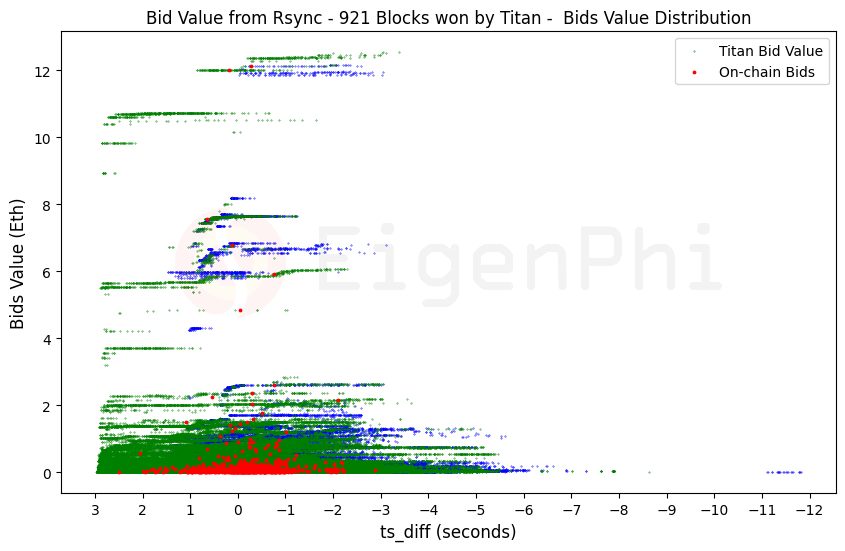

In [38]:

# Draw the charts of Beaverbuild
dft_bidding12s_titan_only = dft_bidding12s[dft_bidding12s['builder_label']=='Titan']

# draw the scatter plot of beaverbuild and rsync only on Tx Count
dft_bidding12s_beaver_only = dft_bidding12s[dft_bidding12s['builder_label']=='beaverbuild']
dft_bidding12s_rsync_only = dft_bidding12s[dft_bidding12s['builder_label']=='rsync']

#find out the biggest and smallest ts_diff_secs for the axis
max_beaver_ts_diff_secs = dft_bidding12s_beaver_only['ts_diff_secs'].max()
min_beaver_ts_diff_secs = dft_bidding12s_beaver_only['ts_diff_secs'].min()

max_rsync_ts_diff_secs = dft_bidding12s_rsync_only['ts_diff_secs'].max()
min_rsync_ts_diff_secs = dft_bidding12s_rsync_only['ts_diff_secs'].min()

max_x_axis = max(max_beaver_ts_diff_secs, max_rsync_ts_diff_secs)
min_x_axis = min(min_beaver_ts_diff_secs, min_rsync_ts_diff_secs)


# Chart1: on Tx Count
bx_num_tx = dft_bidding12s_beaver_only.plot.scatter(x='ts_diff_secs', y='num_tx', figsize=(10,6), color='blue', s=0.1)


dft_bidding12s_titan_only.plot.scatter(x='ts_diff_secs', y='num_tx', color='green', s=0.1, ax=bx_num_tx, label='Titan Bids')

# showing the tx counts of the on-chain bids from Titan
df_blocks.plot.scatter(x='ts_diff_secs', y='num_tx', color='red', s=3, 
                             ax=bx_num_tx, label='On-chain Bids')


adjust_plot_x_axis(bx_num_tx)
bx_num_tx.xaxis.set_major_locator(ticker.MultipleLocator(base=1))  # 设置主要刻度为1秒
plt.xlabel('ts_diff (seconds)', fontsize=12)
plt.ylabel('Bids Tx Count', fontsize=12)
plt.title('921 Blocks won by Titan - Bidding data from beaverbuild & Titan - Tx Counts Distribution')
# Adding watermark using the refactored function
add_watermark(bx_num_tx, image_path='EigenPhi_logo.png', zoom=0.2, alpha=0.05, position=(0.5, 0.5))
plt.show()


# Chart2: on Gas Used
bx_gas = dft_bidding12s_beaver_only.plot.scatter(x='ts_diff_secs', y='gas_used', figsize=(10,6), color='blue', s=0.1)

dft_bidding12s_titan_only.plot.scatter(x='ts_diff_secs', y='gas_used', color='green', s=0.1, ax=bx_gas, label='Titan Bid Gas_used')


# showing the tx counts of the on-chain bids from Titan
df_blocks.plot.scatter(x='ts_diff_secs', y='gas_used', color='red', s=3, 
                             ax=bx_gas, label='On-Chain Bids Gas Used')

adjust_plot_x_axis(bx_gas)
bx_gas.xaxis.set_major_locator(ticker.MultipleLocator(base=1))  # 设置主要刻度为1秒
plt.xlabel('ts_diff (seconds)', fontsize=12)
plt.ylabel('Bids Gas Used', fontsize=12)
plt.title('921 Blocks won by Titan - Bidding data from beaverbuild & Titan - Gas Used Distribution')
# Adding watermark using the refactored function
add_watermark(bx_gas, image_path='EigenPhi_logo.png', zoom=0.2, alpha=0.05, position=(0.5, 0.5))
plt.show()


# Chart3: on Bid Value
# prepping the data for Bid Value scatter plot
dft_bidding12s_beaver_only['bid_transformed'] = dft_bidding12s_beaver_only['value'] / 10 ** 18
dft_bidding12s_titan_only['bid_transformed'] = dft_bidding12s_titan_only['value'] / 10 ** 18

df_blocks['bid_transformed'] = df_blocks['value'] / 10 ** 18

bx_value = dft_bidding12s_beaver_only.plot.scatter(x='ts_diff_secs', y='bid_transformed', figsize=(10,6), color='blue', s=0.1)
dft_bidding12s_titan_only.plot.scatter(x='ts_diff_secs', y='bid_transformed', color='green', s=0.1, ax=bx_value, label='Titan Bid Value')

# showing the bid values of the on-chain bids
df_blocks.plot.scatter(x='ts_diff_secs', y='bid_transformed', color='red', s=3, 
                             ax=bx_value, label='On-chain Bids')


adjust_plot_x_axis(bx_value)
bx_value.xaxis.set_major_locator(ticker.MultipleLocator(base=1))  # 设置主要刻度为1秒
plt.xlabel('ts_diff (seconds)', fontsize=12)
plt.ylabel('Bids Value (Eth)', fontsize=12)
plt.title('Bid Value from Beaver - 921 Blocks won by Titan -  Bids Value Distribution')

# Adding watermark using the refactored function
add_watermark(bx_value, image_path='EigenPhi_logo.png', zoom=0.2, alpha=0.05, position=(0.5, 0.5))

plt.show()



In [17]:
# # draw the scatter plot of beaverbuild only on Tx Count
# beaver_builders = df_builder_info[df_builder_info['builder_label'].str.contains('beaver', case=False, na=False)]
# dft_bidding12s_beaver_only = dft_bidding12s[dft_bidding12s['builder_pubkey'].isin(titan_builders['builder_pubkey'])]